# Train Model

### Imports

In [3]:
import sys
import os
from config import Config
sys.path.append(Config.root_path)

import importlib
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# Load Model
from Python.model.segmentation_model_v2 import deeplabv3plus
# Load Dataset & Preprocessing
from Python.data_processing.utils import get_png_paths_from_dir
from Python.data_processing.utils import load_weight_map
from Python.data_processing.utils import split_dataset_paths
from Python.data_processing.data_generator import generate_image_dataset_from_files
from Python.data_processing.data_generator import augment_dataset
# Print Model Prediction
from Python.data_processing.compare_predictions import show_predictions
# Save Model
from Python.data_processing.save_model import write_model_to_disk

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Prepare dataset

In [4]:
with open(Config.partition_path) as file:
    filepath_partitions = json.load(file)
train_files = filepath_partitions.get("train")
val_files = filepath_partitions.get("validation")
test_files = filepath_partitions.get("test")
weight_map = load_weight_map(Config.weight_map_path)
train_weights = np.zeros(Config.output_channels, dtype=float)
for key in weight_map.keys():
    train_weights[int(key)] = weight_map.get(key)
val_test_weights = np.ones(Config.output_channels, dtype=np.float32)
val_test_weights[Config.background_label] = 0
train_dataset = generate_image_dataset_from_files(
    train_files[0], 
    train_files[1],
    Config.batch_size,
    tf.data.AUTOTUNE, 
    Config.shuffle_size, 
    train_weights
)
val_dataset = generate_image_dataset_from_files(
    val_files[0], 
    val_files[1],
    Config.batch_size,
    tf.data.AUTOTUNE, 
    Config.shuffle_size, 
    val_test_weights
)
test_dataset = generate_image_dataset_from_files(
    test_files[0], 
    test_files[1],
    Config.batch_size,
    tf.data.AUTOTUNE, 
    Config.shuffle_size, 
    val_test_weights
)
train_dataset = augment_dataset(train_dataset)

### Load Model

In [5]:
model = deeplabv3plus(
    Config.input_shape,
    Config.batch_size,
    Config.output_channels,
    Config.channels_low,
    Config.channels_high,
    Config.middle_repeat
)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    Config.initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.94,
    staircase=True) # not sure about this implementation currently


trainable_count = np.sum(
    [tf.keras.backend.count_params(w) for w in model.trainable_weights]
)
print(f"Model: {model.name}\nTrainable parameters: {trainable_count}")
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate= lr_schedule),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics= ["accuracy"],
    weighted_metrics = ["accuracy"]
)

Model: model_v2
Trainable parameters: 11042160


### Compare Image, Segmentation Mask and Prediction

2023-04-07 12:47:27.880776: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-07 12:47:27.880871: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-07 12:47:28.514519: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-07 12:47:28.514613: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

1/1 [==============================] - 11s 11s/step


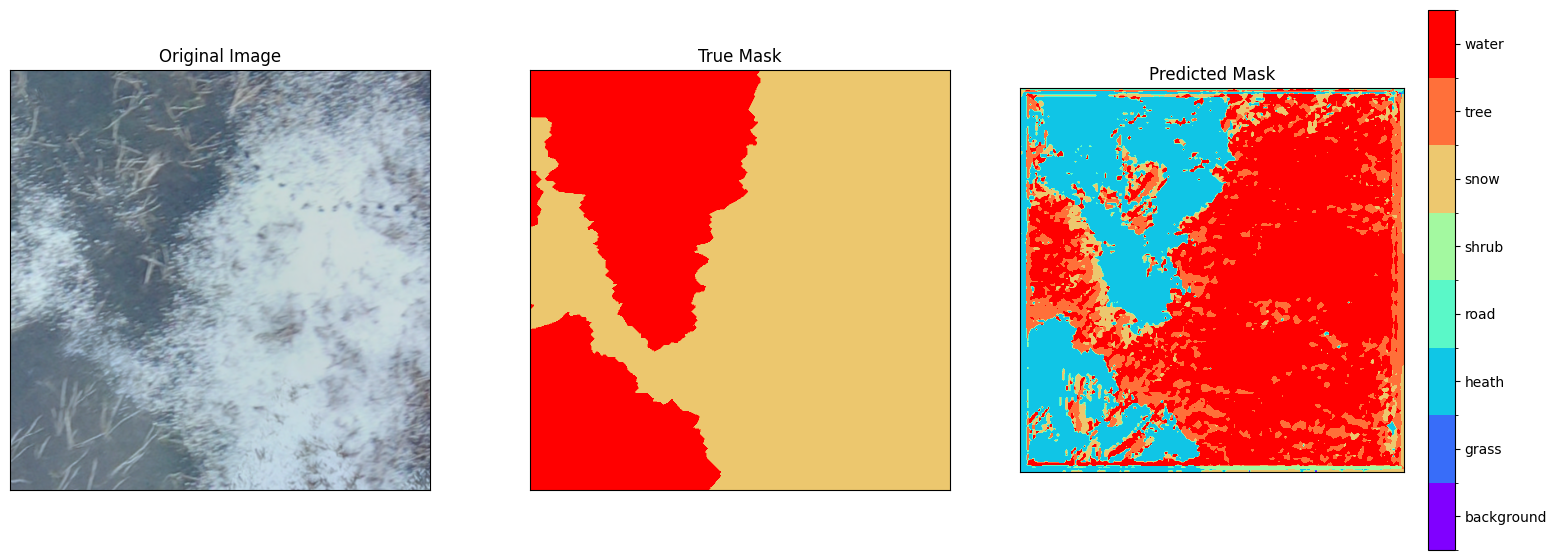

In [6]:
show_predictions(model, train_dataset)

### Model Training

Train Model

In [7]:
# Update any changes to Config
importlib.reload(sys.modules["config"])
from config import Config
# Train model
model_history = model.fit(
    x=train_dataset,
    epochs=Config.epochs,
    validation_data=val_dataset,
    shuffle=True
) 

Epoch 1/100


2023-04-07 12:47:57.440051: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-07 12:47:57.440174: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-07 12:47:58.735449: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-07 12:47:58.735533: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

 4/71 [>.............................] - ETA: 3:01 - loss: 3.1274 - accuracy: 0.1912 - weighted_accuracy: 0.2212

Show Model Performance

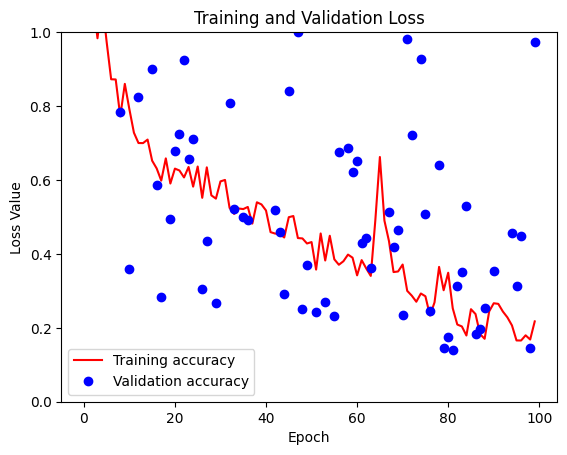

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training accuracy')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation accuracy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Save Model

In [ ]:
train_names = [os.path.split(img_path)[1] for img_path in train_files[0]]
val_names = [os.path.split(img_path)[1] for img_path in val_files[0]]
test_names = [os.path.split(img_path)[1] for img_path in test_files[0]]
file_partitions = dict(
    "train", train_files, "validation", val_files, "test", test_files
)
write_model_to_disk(
    model, model_history, file_partitions, Config.model_dir_path, Config
)

TypeError: dict expected at most 1 argument, got 6